# 06. Additional Analysis

This notebook performs supplementary analyses and cross-analysis insights.

**Sections:**
1. **Stock-Specific Analysis** - Analysis by individual stock tickers
2. **Publisher-Stock Relationships** - Relationships between publishers and stocks they cover
3. **Data Quality Checks** - Additional data quality assessments
4. **Cross-Analysis Insights** - Insights combining multiple analysis dimensions

**Dependencies:** 
- Run all previous notebooks first for complete analysis
- `01_Data_Loading_and_Setup.ipynb` - For processed data
- `03_Text_Analysis.ipynb` - For event detection columns (optional)


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add utils to path
sys.path.append('.')
from utils import setup_plotting_style, load_processed_data

# Setup plotting style
setup_plotting_style()

print("Libraries imported successfully!")


Plotting style configured
Libraries imported successfully!


In [2]:
# Ensure figures directory exists
figures_dir = 'figures'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
    print(f"Created {figures_dir}/ directory")
else:
    print(f"Using existing {figures_dir}/ directory")


Using existing figures/ directory


In [3]:
# Load processed data
try:
    df = load_processed_data('../data/processed/df_processed.pkl')
    print(f"Loaded processed data: {df.shape}")
except FileNotFoundError:
    print("Processed data not found. Loading raw data...")
    from utils import load_data, preprocess_data, clean_data
    df = load_data('../data/raw_analyst_ratings.csv')
    df = clean_data(df, remove_duplicates=True, handle_missing='report', fix_dates=True)
    df = preprocess_data(df)
    print(f"Loaded and preprocessed data: {df.shape}")

print(f"\nDataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Check for event detection columns
event_cols = [col for col in df.columns if col.startswith('event_')]
if event_cols:
    print(f"\nFound {len(event_cols)} event detection columns")
else:
    print("\n⚠ No event detection columns found. Some analyses may be limited.")


Loaded processed data from ../data/processed/df_processed.pkl
Shape: (1407328, 8)
Loaded processed data: (1407328, 8)

Dataset shape: (1407328, 8)
Columns: ['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock', 'headline_length', 'headline_word_count']

⚠ No event detection columns found. Some analyses may be limited.


## 5.1 Stock-Specific Analysis

**Objective:** Analyze news coverage and patterns for individual stock tickers.

**Key Questions:**
- Which stocks receive the most news coverage?
- How does headline length vary by stock?
- What are the publication patterns for different stocks?
- Are there event type differences by stock?


In [4]:
# Stock-specific analysis
print("="*80)
print("STOCK-SPECIFIC ANALYSIS")
print("="*80)

# Basic stock statistics
stock_stats = df.groupby('stock').agg({
    'headline': 'count',
    'headline_length': ['mean', 'median', 'std'],
    'publisher': 'nunique',
    'date': ['min', 'max']
}).reset_index()

# Flatten column names
stock_stats.columns = ['stock', 'total_articles', 'mean_headline_length', 'median_headline_length', 
                      'std_headline_length', 'unique_publishers', 'first_article', 'last_article']

# Calculate date range
stock_stats['date_range_days'] = (pd.to_datetime(stock_stats['last_article']) - 
                                   pd.to_datetime(stock_stats['first_article'])).dt.days + 1
stock_stats['articles_per_day'] = stock_stats['total_articles'] / stock_stats['date_range_days'].replace(0, 1)

# Sort by total articles
stock_stats = stock_stats.sort_values('total_articles', ascending=False).reset_index(drop=True)

print(f"\nTotal unique stocks: {len(stock_stats):,}")
print(f"\nStock Coverage Statistics:")
print("-" * 80)
for idx, row in stock_stats.iterrows():
    print(f"{row['stock']:6s} | Articles: {int(row['total_articles']):>8,} | "
          f"Publishers: {int(row['unique_publishers']):>3d} | "
          f"Mean Length: {row['mean_headline_length']:>5.1f} chars | "
          f"Articles/day: {row['articles_per_day']:>5.2f}")

# Summary statistics
print(f"\n" + "="*80)
print("STOCK SUMMARY STATISTICS")
print("="*80)
print(f"Mean articles per stock: {stock_stats['total_articles'].mean():.1f}")
print(f"Median articles per stock: {stock_stats['total_articles'].median():.1f}")
print(f"Max articles per stock: {int(stock_stats['total_articles'].max()):,}")
print(f"Mean headline length: {stock_stats['mean_headline_length'].mean():.1f} characters")
print(f"Mean publishers per stock: {stock_stats['unique_publishers'].mean():.1f}")


STOCK-SPECIFIC ANALYSIS

Total unique stocks: 6,204

Stock Coverage Statistics:
--------------------------------------------------------------------------------
MRK    | Articles:    3,333 | Publishers: 190 | Mean Length:  82.9 chars | Articles/day: 416.62
MS     | Articles:    3,238 | Publishers: 222 | Mean Length:  70.8 chars | Articles/day: 462.57
NVDA   | Articles:    3,146 | Publishers: 152 | Mean Length:  76.8 chars | Articles/day: 286.00
MU     | Articles:    3,142 | Publishers: 150 | Mean Length:  78.0 chars | Articles/day: 241.69
QQQ    | Articles:    3,106 | Publishers: 110 | Mean Length:  74.1 chars | Articles/day: 517.67
NFLX   | Articles:    3,028 | Publishers: 104 | Mean Length:  80.1 chars | Articles/day: 336.44
M      | Articles:    3,025 | Publishers: 212 | Mean Length:  68.8 chars | Articles/day: 1008.33
EBAY   | Articles:    3,018 | Publishers: 198 | Mean Length:  69.1 chars | Articles/day: 503.00
GILD   | Articles:    2,968 | Publishers: 165 | Mean Length:  83.9 cha

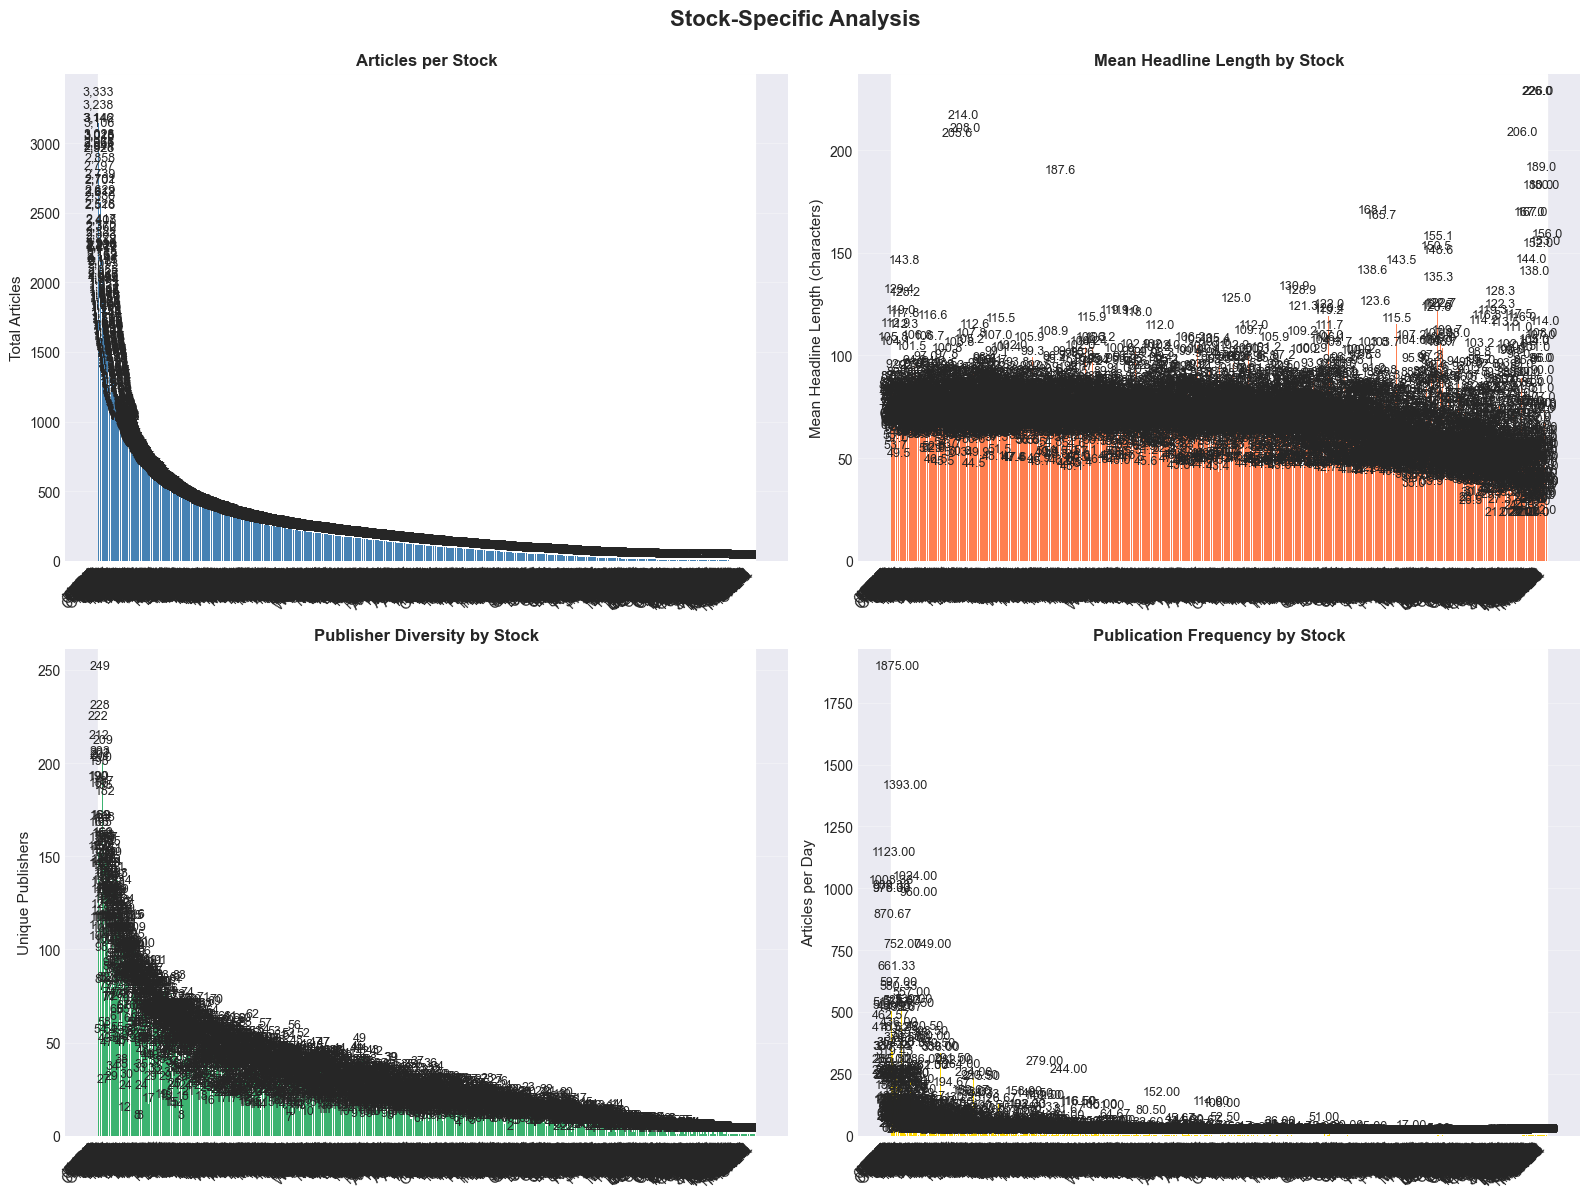

Saved: figures/stock_specific_analysis.png


In [5]:
# Visualize stock-specific analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Stock-Specific Analysis', fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Articles per stock
ax1 = axes[0, 0]
bars1 = ax1.bar(range(len(stock_stats)), stock_stats['total_articles'], color='steelblue')
ax1.set_xticks(range(len(stock_stats)))
ax1.set_xticklabels(stock_stats['stock'], rotation=45, ha='right')
ax1.set_ylabel('Total Articles', fontsize=11)
ax1.set_title('Articles per Stock', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (idx, row) in enumerate(stock_stats.iterrows()):
    ax1.text(i, row['total_articles'], f"{int(row['total_articles']):,}",
            ha='center', va='bottom', fontsize=9)

# Plot 2: Mean headline length by stock
ax2 = axes[0, 1]
bars2 = ax2.bar(range(len(stock_stats)), stock_stats['mean_headline_length'], color='coral')
ax2.set_xticks(range(len(stock_stats)))
ax2.set_xticklabels(stock_stats['stock'], rotation=45, ha='right')
ax2.set_ylabel('Mean Headline Length (characters)', fontsize=11)
ax2.set_title('Mean Headline Length by Stock', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (idx, row) in enumerate(stock_stats.iterrows()):
    ax2.text(i, row['mean_headline_length'], f"{row['mean_headline_length']:.1f}",
            ha='center', va='bottom', fontsize=9)

# Plot 3: Unique publishers per stock
ax3 = axes[1, 0]
bars3 = ax3.bar(range(len(stock_stats)), stock_stats['unique_publishers'], color='mediumseagreen')
ax3.set_xticks(range(len(stock_stats)))
ax3.set_xticklabels(stock_stats['stock'], rotation=45, ha='right')
ax3.set_ylabel('Unique Publishers', fontsize=11)
ax3.set_title('Publisher Diversity by Stock', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (idx, row) in enumerate(stock_stats.iterrows()):
    ax3.text(i, row['unique_publishers'], f"{int(row['unique_publishers'])}",
            ha='center', va='bottom', fontsize=9)

# Plot 4: Articles per day by stock
ax4 = axes[1, 1]
bars4 = ax4.bar(range(len(stock_stats)), stock_stats['articles_per_day'], color='gold')
ax4.set_xticks(range(len(stock_stats)))
ax4.set_xticklabels(stock_stats['stock'], rotation=45, ha='right')
ax4.set_ylabel('Articles per Day', fontsize=11)
ax4.set_title('Publication Frequency by Stock', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (idx, row) in enumerate(stock_stats.iterrows()):
    ax4.text(i, row['articles_per_day'], f"{row['articles_per_day']:.2f}",
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('figures/stock_specific_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: figures/stock_specific_analysis.png")


## 5.2 Publisher-Stock Relationships

**Objective:** Analyze relationships between publishers and the stocks they cover.

**Key Questions:**
- Which publishers cover which stocks?
- Are there publishers that specialize in specific stocks?
- What is the overlap in stock coverage between publishers?


In [6]:
# Publisher-stock relationships
print("="*80)
print("PUBLISHER-STOCK RELATIONSHIPS")
print("="*80)

# Create publisher-stock matrix
publisher_stock_counts = df.groupby(['publisher', 'stock']).size().reset_index(name='article_count')
publisher_stock_pivot = publisher_stock_counts.pivot(index='publisher', columns='stock', values='article_count').fillna(0)

# Get top publishers and all stocks
top_publishers = df.groupby('publisher').size().nlargest(15).index
all_stocks = sorted(df['stock'].unique())

print(f"\nAnalyzing relationships for top 15 publishers and {len(all_stocks)} stocks...")

# Calculate coverage statistics
publisher_coverage = {}
for pub in top_publishers:
    if pub in publisher_stock_pivot.index:
        stocks_covered = (publisher_stock_pivot.loc[pub] > 0).sum()
        total_articles = publisher_stock_pivot.loc[pub].sum()
        publisher_coverage[pub] = {
            'stocks_covered': stocks_covered,
            'total_articles': total_articles,
            'avg_articles_per_stock': total_articles / stocks_covered if stocks_covered > 0 else 0
        }

print(f"\nPublisher Coverage Statistics:")
print("-" * 80)
for pub, stats in sorted(publisher_coverage.items(), key=lambda x: x[1]['stocks_covered'], reverse=True):
    print(f"{pub:40s} | Stocks: {stats['stocks_covered']:>3d} | "
          f"Articles: {int(stats['total_articles']):>6,} | "
          f"Avg/Stock: {stats['avg_articles_per_stock']:>6.1f}")

# Find stock specialists (publishers covering few stocks with high concentration)
print(f"\n" + "="*80)
print("STOCK SPECIALIZATION ANALYSIS")
print("="*80)
for stock in all_stocks:
    stock_publishers = publisher_stock_counts[publisher_stock_counts['stock'] == stock].sort_values('article_count', ascending=False)
    top_pub = stock_publishers.head(1)
    if len(top_pub) > 0:
        top_pub_name = top_pub.iloc[0]['publisher']
        top_pub_count = int(top_pub.iloc[0]['article_count'])
        total_stock_articles = stock_publishers['article_count'].sum()
        pct = (top_pub_count / total_stock_articles * 100) if total_stock_articles > 0 else 0
        print(f"{stock:6s} | Top Publisher: {top_pub_name:40s} | "
              f"{top_pub_count:>6,} articles ({pct:>5.1f}% of {stock} coverage)")


PUBLISHER-STOCK RELATIONSHIPS

Analyzing relationships for top 15 publishers and 6204 stocks...

Publisher Coverage Statistics:
--------------------------------------------------------------------------------
Paul Quintaro                            | Stocks: 4703 | Articles: 228,373 | Avg/Stock:   48.6
Lisa Levin                               | Stocks: 4640 | Articles: 186,979 | Avg/Stock:   40.3
Hal Lindon                               | Stocks: 4474 | Articles: 49,047 | Avg/Stock:   11.0
Eddie Staley                             | Stocks: 4466 | Articles: 57,254 | Avg/Stock:   12.8
Charles Gross                            | Stocks: 4181 | Articles: 96,732 | Avg/Stock:   23.1
Benzinga Newsdesk                        | Stocks: 4049 | Articles: 150,484 | Avg/Stock:   37.2
Monica Gerson                            | Stocks: 4012 | Articles: 82,380 | Avg/Stock:   20.5
Benzinga Staff                           | Stocks: 3233 | Articles: 28,114 | Avg/Stock:    8.7
Benzinga_Newsdesk           

ValueError: The number of FixedLocator locations (62), usually from a call to set_ticks, does not match the number of labels (6204).

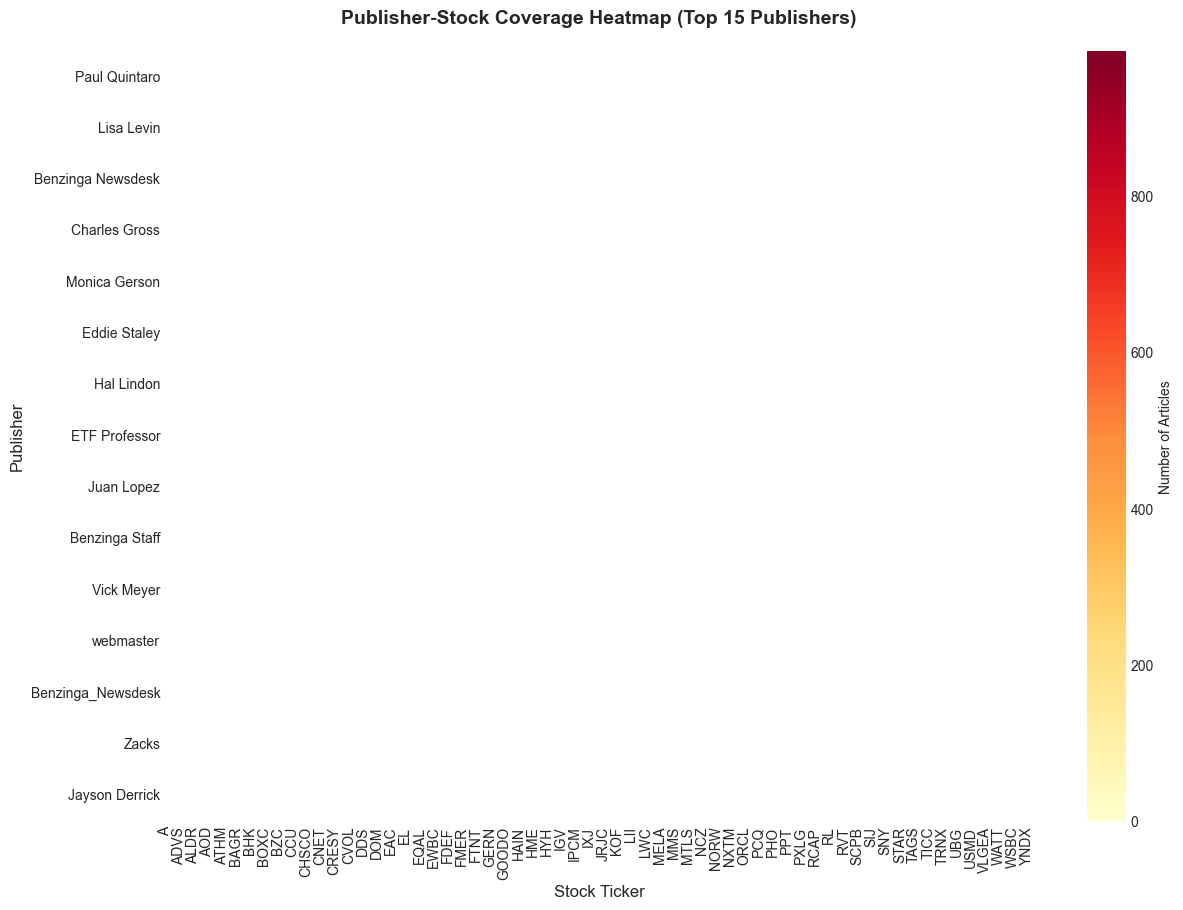

In [7]:
# Visualize publisher-stock relationships
# Create heatmap for top publishers and all stocks
heatmap_data = publisher_stock_pivot.loc[top_publishers, all_stocks]

# Visualize
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=False, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Number of Articles'}, ax=ax, linewidths=0.5)
ax.set_xlabel('Stock Ticker', fontsize=12)
ax.set_ylabel('Publisher', fontsize=12)
ax.set_title('Publisher-Stock Coverage Heatmap (Top 15 Publishers)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticklabels(all_stocks, rotation=0, fontsize=9)
ax.set_yticklabels(top_publishers, rotation=0, fontsize=8)

plt.tight_layout()
plt.savefig('figures/publisher_stock_relationships.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: figures/publisher_stock_relationships.png")


## 5.3 Data Quality Checks

**Objective:** Perform additional data quality assessments and identify potential issues.

**Key Questions:**
- Are there data quality issues that need attention?
- What is the distribution of missing values?
- Are there anomalies in the data?


In [ ]:
# Additional data quality checks
print("="*80)
print("ADDITIONAL DATA QUALITY CHECKS")
print("="*80)

# Check for missing values
missing_values = df.isnull().sum()
missing_pct = (missing_values / len(df)) * 100

print(f"\nMissing Values by Column:")
print("-" * 80)
for col in df.columns:
    if missing_values[col] > 0:
        print(f"  {col:30s}: {missing_values[col]:>8,} ({missing_pct[col]:>5.2f}%)")

if missing_values.sum() == 0:
    print("  ✓ No missing values found")

# Check for duplicate headlines
duplicate_headlines = df.duplicated(subset=['headline']).sum()
print(f"\nDuplicate Headlines: {duplicate_headlines:,} ({duplicate_headlines/len(df)*100:.2f}%)")

# Check for duplicate URLs
if 'url' in df.columns:
    duplicate_urls = df.duplicated(subset=['url']).sum()
    print(f"Duplicate URLs: {duplicate_urls:,} ({duplicate_urls/len(df)*100:.2f}%)")

# Check for invalid dates
if 'date' in df.columns:
    invalid_dates = df['date'].isna().sum()
    print(f"Invalid/Missing Dates: {invalid_dates:,} ({invalid_dates/len(df)*100:.2f}%)")

# Check for empty headlines
empty_headlines = (df['headline'].str.strip() == '').sum()
print(f"Empty Headlines: {empty_headlines:,} ({empty_headlines/len(df)*100:.2f}%)")

# Check for very short headlines (potential data quality issue)
very_short = (df['headline_length'] < 5).sum()
print(f"Very Short Headlines (<5 chars): {very_short:,} ({very_short/len(df)*100:.2f}%)")

# Check for very long headlines (potential data quality issue)
very_long = (df['headline_length'] > 300).sum()
print(f"Very Long Headlines (>300 chars): {very_long:,} ({very_long/len(df)*100:.2f}%)")

# Check stock distribution
print(f"\n" + "="*80)
print("STOCK DISTRIBUTION")
print("="*80)
stock_dist = df['stock'].value_counts()
print(f"Stocks with articles:")
for stock, count in stock_dist.items():
    pct = count / len(df) * 100
    print(f"  {stock:6s}: {count:>8,} articles ({pct:>5.2f}%)")


## 5.4 Cross-Analysis Insights

**Objective:** Combine insights from multiple analysis dimensions to identify patterns.

**Key Questions:**
- How do stocks, publishers, and events interact?
- Are there correlations between different dimensions?
- What are the key cross-cutting insights?


In [ ]:
# Cross-analysis insights
print("="*80)
print("CROSS-ANALYSIS INSIGHTS")
print("="*80)

# Stock-Event relationships (if event columns exist)
if event_cols:
    print(f"\n1. STOCK-EVENT RELATIONSHIPS")
    print("-" * 80)
    
    # Calculate event counts by stock
    stock_event_counts = df.groupby('stock')[event_cols].sum()
    
    # Find most common events per stock
    for stock in all_stocks:
        if stock in stock_event_counts.index:
            stock_events = stock_event_counts.loc[stock].sort_values(ascending=False)
            top_event = stock_events.head(1)
            if top_event.values[0] > 0:
                event_name = top_event.index[0].replace('event_', '').replace('_', ' ').title()
                event_count = int(top_event.values[0])
                total_stock_articles = df[df['stock'] == stock].shape[0]
                pct = (event_count / total_stock_articles * 100) if total_stock_articles > 0 else 0
                print(f"  {stock:6s}: Top event = {event_name:25s} ({event_count:>5,} articles, {pct:>5.1f}%)")
    
    # Visualize stock-event relationships
    fig, ax = plt.subplots(figsize=(12, 8))
    stock_event_pct = stock_event_counts.div(df.groupby('stock').size(), axis=0) * 100
    top_events = stock_event_counts.sum().nlargest(5).index
    sns.heatmap(stock_event_pct[top_events], annot=True, fmt='.1f', cmap='YlOrRd',
                cbar_kws={'label': 'Event Percentage (%)'}, ax=ax, linewidths=0.5)
    ax.set_xlabel('Event Type', fontsize=12)
    ax.set_ylabel('Stock', fontsize=12)
    ax.set_title('Event Distribution by Stock (Top 5 Events)', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticklabels([e.replace('event_', '').replace('_', ' ').title() for e in top_events], 
                       rotation=45, ha='right', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('figures/stock_event_relationships.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\nSaved: figures/stock_event_relationships.png")

# Publisher-Stock-Event relationships
if event_cols:
    print(f"\n2. PUBLISHER-STOCK-EVENT RELATIONSHIPS")
    print("-" * 80)
    
    # Find publishers with highest event coverage for each stock
    for stock in all_stocks[:5]:  # Show top 5 stocks
        stock_df = df[df['stock'] == stock]
        if len(stock_df) > 0:
            top_event_col = stock_df[event_cols].sum().idxmax()
            top_event_name = top_event_col.replace('event_', '').replace('_', ' ').title()
            top_pub = stock_df.groupby('publisher')[top_event_col].sum().nlargest(1)
            if len(top_pub) > 0:
                pub_name = top_pub.index[0]
                event_count = int(top_pub.values[0])
                print(f"  {stock:6s} | Top Event: {top_event_name:25s} | "
                      f"Top Publisher: {pub_name:40s} ({event_count:,} articles)")

# Headline length by stock and publisher
print(f"\n3. HEADLINE LENGTH PATTERNS")
print("-" * 80)
for stock in all_stocks:
    stock_df = df[df['stock'] == stock]
    if len(stock_df) > 0:
        mean_len = stock_df['headline_length'].mean()
        top_pub = stock_df.groupby('publisher').size().nlargest(1).index[0]
        top_pub_mean_len = stock_df[stock_df['publisher'] == top_pub]['headline_length'].mean()
        print(f"  {stock:6s}: Mean length = {mean_len:>5.1f} chars | "
              f"Top publisher ({top_pub[:30]:30s}): {top_pub_mean_len:>5.1f} chars")


## Summary

**Key Insights from Additional Analysis:**

1. **Stock-Specific Patterns:**
   - [To be filled after running the notebook]

2. **Publisher-Stock Relationships:**
   - [To be filled after running the notebook]

3. **Data Quality:**
   - [To be filled after running the notebook]

4. **Cross-Analysis Insights:**
   - [To be filled after running the notebook]
